In [ ]:
import pandas as pd

data_an = open("myCHD801FR_20221123_normal_annotated.txt")#open and read file
r = data_an.read()
data_an.close()

rlist = list(r.split("\n"))#list of each row (strings)
commas = []
for line in rlist:
    commas.append(list(line.split(",")))#add a list of all the elements of each row split by commas

annote = pd.DataFrame(commas)

#rename the columns from default range 
annote = annote.rename(columns={1: "sleep_state", 2: "time_elapsed", 3:"date_time", 4: "1010", 5: "321"})

#they record both the current stage and the new stage whenever there is a change so i think the 1010 column keeps track 
#of whether a stage is ending(0) or starting(1), it makes more sense if you look at the data 
#im pretty sure the 321 column is just numerically representing REM(1), non-REM(2) and wake(3)

annote["time_elapsed"] = pd.to_numeric(annote["time_elapsed"])
annote["date_time"] = pd.to_datetime(annote["date_time"])
annote.head()

,0,sleep_state,time_elapsed,date_time,1010,321
0,Start-end,W,0.040,2022-11-23 08:00:00,1,3
1,Start-end,W,1703.070,2022-11-23 08:28:23,0,3
2,Start-end,N,1703.070,2022-11-23 08:28:23,1,2
3,Start-end,N,1707.985,2022-11-23 08:28:27,0,2
4,Start-end,W,1707.985,2022-11-23 08:28:27,1,3


In [ ]:
eeg_file = open("C:\\Users\\regan\\Downloads\\CHDCtrl1_CHD801FR_normal\\CHD801FR_20221123_normal.txt")
r_eeg = eeg_file.read()
eeg_file.close()

r_eeg = r_eeg[95:]#gets rid of this text: 
#"emp.tmen A total of 20278848 data points, sampling rate: 200 Hz,Time format: min : sec. msec"

e_split = list(r_eeg.split("\n"))

In [ ]:
spaces = []
for line in e_split: 
    s = list(line.split("\t"))
    #this is kinda dumb but theres some weird spacing and i didn't feel like actually figuring out how to split it nicely
    #so i just removed all the extra ' ' elements that spliting on tabs added
    for i in s:    
        if i == ' ':
            s.remove(' ')
    
    spaces.append(s)

In [ ]:
eeg = pd.DataFrame(spaces[4:])
#i got rid of the first 3 rows cause they caused me issues at some point, i don't even remeber why

In [ ]:
eeg[1] = pd.to_datetime(eeg[1], format=' %M:%S.%f ',  errors = 'ignore')
#once you hit an hour, to datetime doesn't work anymore becuase the minutes just keep adding without converting to hours 
#you cam see if you get rid of the errors = 'ignore', i didn't feel like thinking too much about how we want to handle the 
#times and matching them in the two datasets cause there's like 3 different ways its formatted
eeg[2] = pd.to_numeric(eeg[2])
eeg[3] = pd.to_numeric(eeg[3])



In [ ]:
eeg.head()

,0,1,2,3
0,2,00:00.004,0.23,-0.14
1,3,00:00.009,0.20,-0.63
2,4,00:00.014,0.29,-0.44
3,5,00:00.019,0.23,0.13
4,6,00:00.024,0.22,0.00


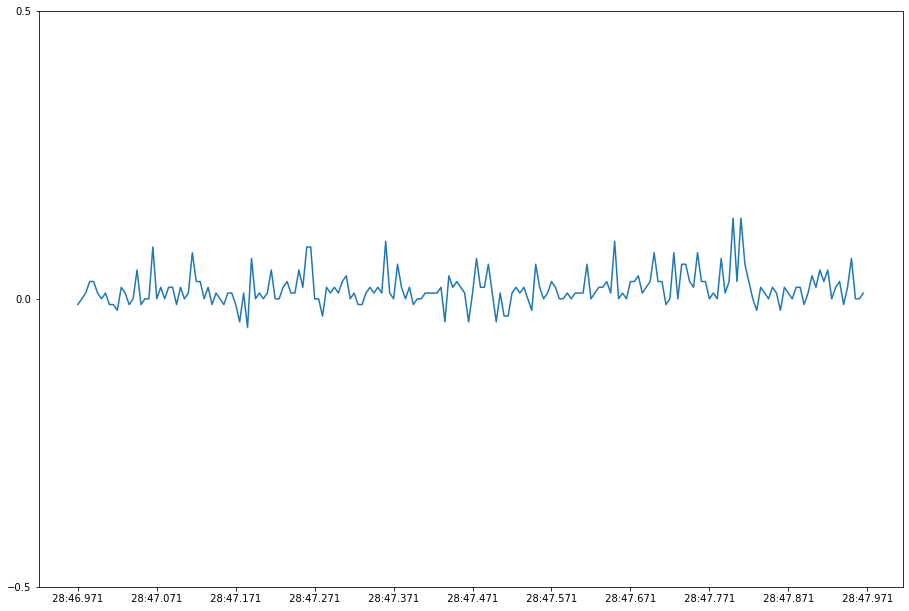

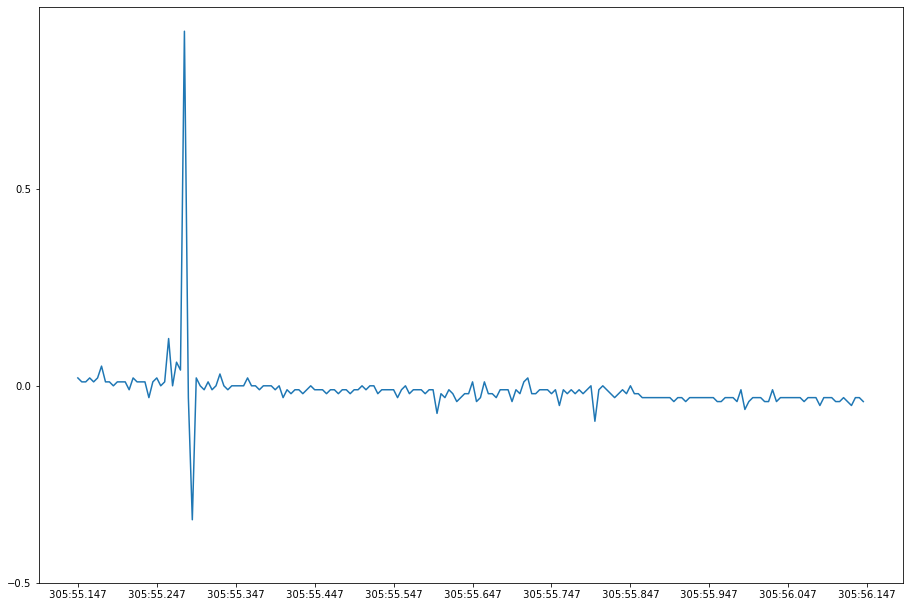

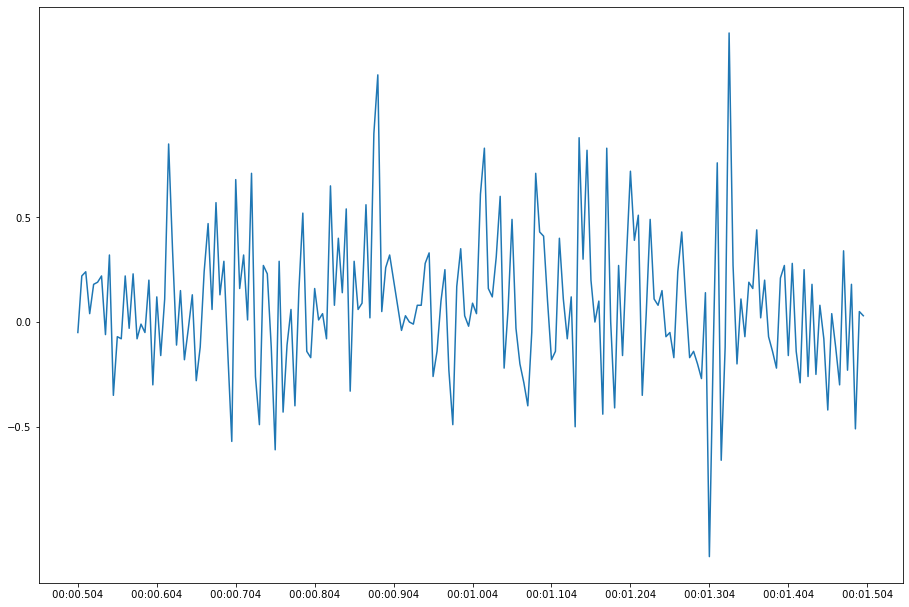

In [ ]:
import matplotlib.pyplot as plt

#makes a plot of 200 points of eeg data starting from whatever index you use as the arguement, i chose 200 pretty much arbitrarily
#most of the code is just me trying to fix the axis cause it comes out wonky if you just plot it 
def makeplot(x):
    xAxis = []
    for i in range(11):
        xAxis.append(x + i*20)
        i+= 1 
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    plt.plot(eeg[1][x:x+200], eeg[3][x:x+200])#if you want to change how many points to plot just swap out the 200s
    
    ax.set_yticks([-.5, 0, .5])
    ax.set_xticks(eeg[1][xAxis]) 
    plt.show()
    
makeplot(345400) #non rem
makeplot(3671100) #rem
makeplot(100) #wake

Text(0.5, 1.0, 'Wake')

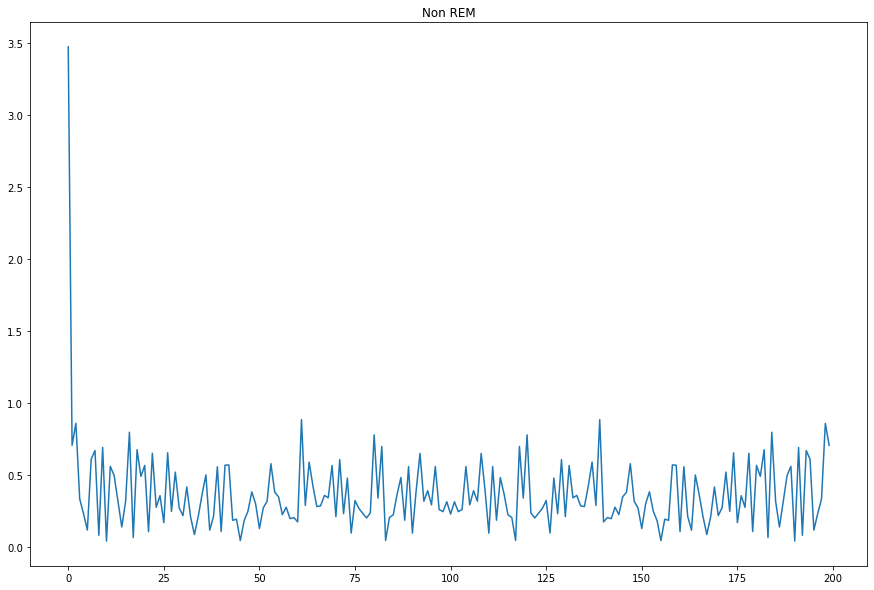

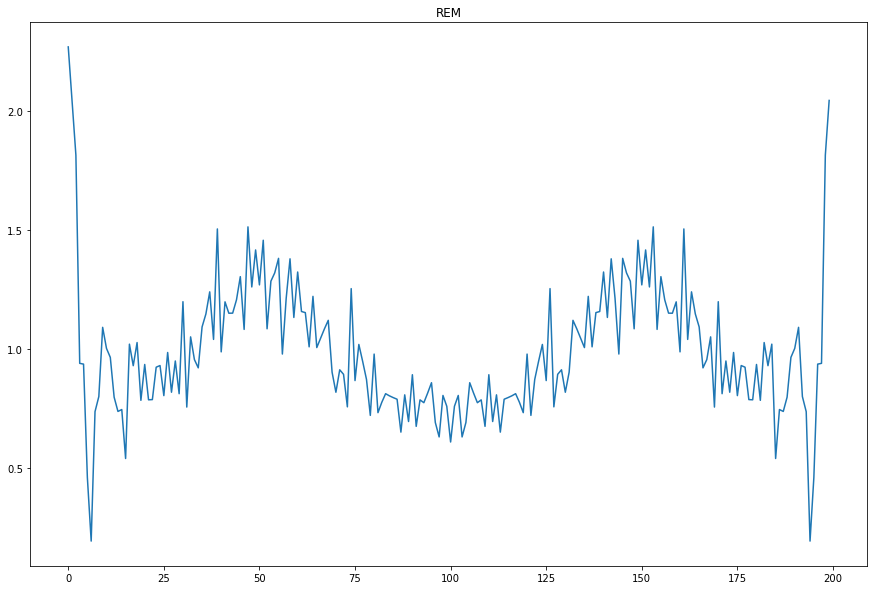

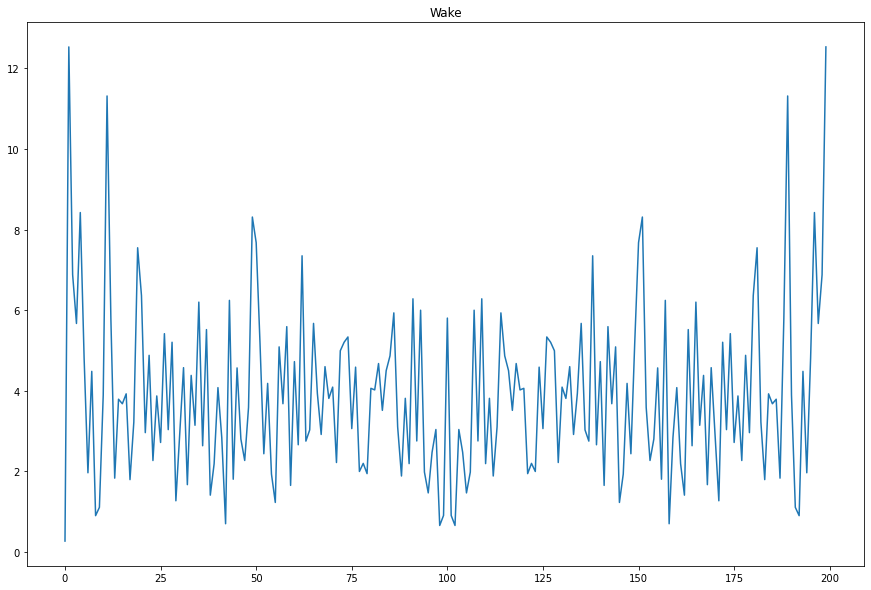

In [ ]:
#i tried and failed to understand what fast fourier transforms do becuase one of the articles used them and i do think they 
#would be useful but I just couldn't figure out what the fuck they do
#here's what I know:
# - its got something to do with approximating the function of a funky wave graph that is made up of discrete points
#(thats what eeg data is) with sin and cosine functions (like taylor series)
# - i think the graph running this code produces is maybe something like how frequently(y axis) different amplitudes(x axis)
#show up in a set of points but i could literally be completely wrong
#I don't think i have enough math backgroud to really understand what they are and tbh i never really understood the unit
#circle but hopefully someone else can figure them out cause i saw some people do some important looking stuff with them 

#I basically just copied this code but you can see what the graphs look like for different sleep stages 
import numpy as np
 
rem = np.fft.fft(eeg[3][3671100:3671300])
non_rem = np.fft.fft(eeg[3][345400:345600])
wake = np.fft.fft(eeg[3][0:200])

samPerSec = 200
samps = 200
n = np.arange(samps)
T = samps/samPerSec
freq = n/T


fig2 = plt.figure(figsize=(15,10))
plt.plot(freq, np.abs(non_rem))
plt.title("Non REM")

fig3 = plt.figure(figsize=(15,10))
plt.plot(freq, np.abs(rem))
plt.title("REM")

fig2 = plt.figure(figsize=(15,10))
plt.plot(freq, np.abs(wake))
plt.title("Wake")

In [ ]:
""""
draft idea for model (for rn, based on tinysleepnet & baroquerock)
- one convolutional layer
- max pool
- dropout
- one convolutional layer + relu
- one convolutional layer + relu
- one convolutional layer + relu
- flatten
- dense layer
- softmax



def Class sleepModel():

    # output size is 4 for number of classes
    def __init__(self, input_size=?, n_features=?, output_size=4, sample_rate=100):
        super(sleepModel, self).__init__()
        self.n_features = n_features

        self.xconv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=sample_rate // 2)

        self.dropout = nn.Dropout(0.5)

        self.xconv2 = nn.Conv1d(128, 128, kernel_size=8, stride=1)

        self.xconv3 = nn.Conv1d(128, 128, kernel_size=8, stride=1)

        self.xconv4 = nn.Conv1d(128, 128, kernel_size=8, stride=1)

        self.yconv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=sample_rate // 2, stride = sample_rate // 2)

        self.yconv2 = nn.Conv1d(128, 128, kernel_size=6)

        self.yconv3 = nn.Conv1d(128, 128, kernel_size=6)

        self.yconv4 = nn.Conv1d(128, 128, kernel_size=6)

        self.fc1 = nn.Linear(128, 128)

        self.fc2 = nn.Linear(128, 4)

        
    def forward(self, x, y):
        x = self.xconv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool1d(x, kernel_size=8, stride=8)

        x = self.dropout(x)

        x = self.xconv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool1d(x, kernel_size=4)

        x = self.xconv3(x)
        x = torch.nn.functional.relu(x)

        x = self.xconv4(x)
        x = torch.nn.functional.relu(x)

        y = self.xconv1(y)
        y = torch.nn.functional.relu(y)
        y = torch.nn.functional.max_pool1d(y, kernel_size=8, stride=8)

        y = self.xconv2(y)
        y = torch.nn.functional.relu(y)

        y = self.xconv3(y)
        y = torch.nn.functional.relu(y)

        y = self.xconv4(y)
        y = torch.nn.functional.relu(y)

        xy = torch.cat((x, y), 1)
        
        xy = self.fc1(xy)
        pool_size = int(output.shape[1]) // 4
        xy = torch.nn.functional.max_pool1d(y, kernel_size=pool_size, stride=pool_size)

        # flatten it somehow using xy.view()

        xy = self.fc2(xy)
        x = torch.nn.functional.log_softmax(x, dim=1)

        return xy
"""